In [18]:
# Importing required libraries


import pandas as pd
import text_utils
import model_utils
import configs
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Debugging

In [33]:
from fastapi import FastAPI
import torch
import model_utils
import configs
from pydantic import BaseModel
import numpy as np
import text_utils

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

app = FastAPI(title="NLP tester", description="API for NLP use cases", version="1.0")

model = model_utils.BiLSTM(configs.hidden_size,configs.num_classes,configs.dropout,
configs.max_features,configs.embed_size,np.zeros((configs.max_features, configs.embed_size)))
model.load_state_dict(torch.load('./model_files/bilstm.pt'))

# Loading tokenizer

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# Importing label encoder
with open('label_encoder.pkl', 'rb') as handle:
    le = pickle.load(handle)

In [31]:
# Define the prediction function
def predict_single(x):    
    # clean the text
    processor=text_utils.text_processor()
    x = processor.process_text(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=configs.maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long)

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

# define the Input class
class Input(BaseModel):
    text : str


In [27]:
def get_prediction(text):
    data = text
    print(data)
    prediction = predict_single(data).tolist()
    return {"prediction": prediction}

In [34]:
import requests,json
payload = json.dumps({
  "text" : "NLP tester is bad"
})
a=get_prediction(payload)
a

{"text": "NLP tester is bad"}


c:\users\pranavj\appdata\local\continuum\anaconda3\envs\info_surfacing\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


{'prediction': 'Extremely Negative'}

In [42]:
import requests,json
payload = json.dumps({
  'text' : 'NLP tester is bad'
})
response = requests.put("http://127.0.0.1:8000/predict",data = payload)
#data_dict = response.json
#data_dict
response

<Response [405]>

In [15]:
## Main code

In [16]:
%load_ext autoreload
%autoreload 2

In [19]:
# Importing data

train=pd.read_csv('./Corona_NLP_train.csv',encoding='latin1')
test=pd.read_csv('./Corona_NLP_test.csv')
print('Number of training shape',train.shape)
print('Number of testing records',test.shape)
print('Number of unique labels in train',train['Sentiment'].nunique())
print('Number of unique labels in test',test['Sentiment'].nunique())

Number of training shape (41157, 6)
Number of testing records (3798, 6)
Number of unique labels in train 5
Number of unique labels in test 5


In [20]:
# Seeding everything for reproducability
text_utils.seed_everything()

In [21]:
# Text classification pipeline

processor=text_utils.text_processor()
train['cleaned_tweet']=train['OriginalTweet'].apply(lambda x:processor.process_text(x))
test['cleaned_tweet']=test['OriginalTweet'].apply(lambda x:processor.process_text(x))
train.head()       

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,cleaned_tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,tag tag tag weblink and weblink and weblink
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


<AxesSubplot:ylabel='Frequency'>

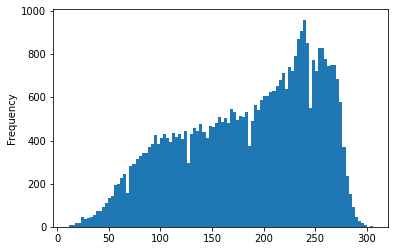

In [22]:
# Check word count distribution to identify the length of the sequence (max_len)
lengths = train['cleaned_tweet'].apply(lambda s : len(s))
lengths.plot.hist(bins=100)

In [23]:
## Tokenize the sentences and pad sequences

tokenizer = Tokenizer(num_words=configs.max_features)
tokenizer.fit_on_texts(list(train['cleaned_tweet']))
train_X = tokenizer.texts_to_sequences(train['cleaned_tweet'])
test_X = tokenizer.texts_to_sequences(test['cleaned_tweet'])

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=configs.maxlen)
test_X = pad_sequences(test_X, maxlen=configs.maxlen)

In [24]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Encoding output variable
le = LabelEncoder()
train_y = le.fit_transform(list(train['Sentiment']))
test_y = le.transform(list(test['Sentiment']))

# Savign label encoder for inference pipeline
output = open('label_encoder.pkl', 'wb')
pickle.dump(le, output)
output.close()

In [ ]:
# Loading the embedding matrix from glove pretrained embedding

embedding_matrix = text_utils.load_glove(tokenizer.word_index,configs.max_features)

In [ ]:
# Loading model architecture

model=model_utils.BiLSTM(configs.hidden_size,configs.num_classes,configs.dropout,configs.max_features,configs.embed_size,
                         embedding_matrix)

In [ ]:
# GPU check

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

In [ ]:
# Loading data and model configurations

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


# Convert train and test numpy arrays as tensors
x_train = torch.tensor(train_X, dtype=torch.long)
y_train = torch.tensor(train_y, dtype=torch.long)
x_cv = torch.tensor(test_X, dtype=torch.long)
y_cv = torch.tensor(test_y, dtype=torch.long)

# Packaging features and labels together
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Loading into data loader for batch operation
train_loader = torch.utils.data.DataLoader(train, batch_size=configs.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=configs.batch_size, shuffle=False)


In [ ]:
# Training the model

train_loss = []
valid_loss = []

for epoch in range(configs.n_epochs):
    start_time = time.time()
    model.train()
    avg_loss = 0  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        # Back prop
        optimizer.zero_grad()
        loss.backward()
        # Optimizer step
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

In [ ]:
# Saving model weights

torch.save(model.state_dict(), './bilstm.pt')